<a href="https://colab.research.google.com/github/csnsnigdha18/Time-Series-Forecasting-and-Point-Anomaly-Detection-of-Sensor-Signals-Using-LSTM-Neural-Network-Arch/blob/main/Code/Multivarient_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [ ]:
#Read the csv file
df = pd.read_csv('/content/GE.csv')
print(df.head()) #7 columns, including the Date.

         Date        Open        High         Low       Close   Adj Close  \
0  2021-10-11  104.839996  105.760002  103.970001  104.080002  103.643105   
1  2021-10-12  103.559998  104.040001  101.559998  102.720001  102.288811   
2  2021-10-13  102.199997  103.199997  101.180000  102.360001  101.930321   
3  2021-10-14  103.139999  103.650002  102.370003  102.739998  102.308723   
4  2021-10-15  103.650002  105.900002  103.190002  104.410004  103.971725   

    Volume  
0  4121800  
1  8549600  
2  7517000  
3  6139100  
4  5650300  


In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.


237   2022-09-20
238   2022-09-21
239   2022-09-22
240   2022-09-23
241   2022-09-26
242   2022-09-27
243   2022-09-28
244   2022-09-29
245   2022-09-30
246   2022-10-03
247   2022-10-04
248   2022-10-05
249   2022-10-06
250   2022-10-07
251   2022-10-10
Name: Date, dtype: datetime64[ns]


In [ ]:
#Variables for training
cols = list(df)[1:6]

In [ ]:
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']


['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [ ]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
14/14 [==============================] - 8s 111ms/step - loss: 0.4729 - val_loss: 0.2204
Epoch 2/5
14/14 [==============================] - 0s 35ms/step - loss: 0.1706 - val_loss: 0.2048
Epoch 3/5
14/14 [==============================] - 1s 39ms/step - loss: 0.1347 - val_loss: 0.0842
Epoch 4/5
14/14 [==============================] - 1s 36ms/step - loss: 0.1228 - val_loss: 0.1009
Epoch 5/5
14/14 [==============================] - 0s 32ms/step - loss: 0.1124 - val_loss: 0.0936


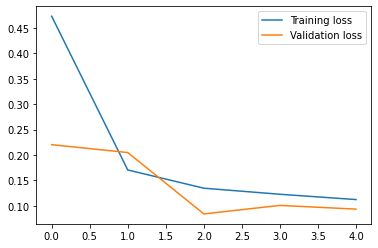

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-09-19 00:00:00', freq='C'), Timestamp('2022-09-20 00:00:00', freq='C'), Timestamp('2022-09-21 00:00:00', freq='C'), Timestamp('2022-09-22 00:00:00', freq='C'), Timestamp('2022-09-23 00:00:00', freq='C'), Timestamp('2022-09-26 00:00:00', freq='C'), Timestamp('2022-09-27 00:00:00', freq='C'), Timestamp('2022-09-28 00:00:00', freq='C'), Timestamp('2022-09-29 00:00:00', freq='C'), Timestamp('2022-09-30 00:00:00', freq='C'), Timestamp('2022-10-03 00:00:00', freq='C'), Timestamp('2022-10-04 00:00:00', freq='C'), Timestamp('2022-10-05 00:00:00', freq='C'), Timestamp('2022-10-06 00:00:00', freq='C'), Timestamp('2022-10-07 00:00:00', freq='C')]


In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


1/1 [==============================] - 0s 384ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resu

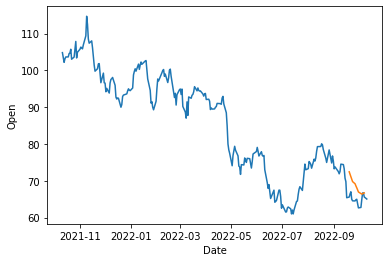

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])